<a href="https://colab.research.google.com/github/BrianDL/fisica_computacional/blob/main/3%20-%20Modelo%20de%20Ising/ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import time
import pickle
import asyncio
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Parte 1. Modelo de Ising

## 1. Calculo de la energía

In [22]:
### Comenzamos con la función de calculo de la energía

def calcular_energia(red, H, J):
    """
    Calcula la energía del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción

    Retorna:
    float: Energía total del sistema
    """
    L = red.shape[0]
    energia = 0
    magnetizacion = 0

    for i in range(L):
        for j in range(L):
            spin = red[i, j]
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]

            energia += -J * spin * vecinos - H * spin
            magnetizacion += spin

    E = energia / 2  # Dividir por 2 para evitar contar dos veces
    M = magnetizacion / (L**2)

    return (E,M)

def calcular_magnetizacion(red):
  L = red.shape[0]
  return sum([ red[i][j] \
              for i in range(L) \
              for j in range(L) ]) / (L**2)



### Probamos la funcionalidad
L = 10  # Tamaño de la red
H = 0.1  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción

# Crear una red inicial aleatoria
red_inicial = np.random.choice([-1, 1], size=(L, L))

# Calcular energía y magnetización iniciales
energia_inicial, magnetizacion_inicial = calcular_energia(red_inicial, H, J)

assert magnetizacion_inicial == calcular_magnetizacion(red_inicial), "La magnetización debe ser la misma"

print(f"Energía inicial: {energia_inicial}")
print(f"Magnetización inicial: {magnetizacion_inicial}")



Energía inicial: 12.400000000000006
Magnetización inicial: -0.08


## 2. Implementando el Algoritmo de Metrópolis

In [23]:
def metropolis_ising(L, H, J, beta, N, inicializacion='frio'):
    """
    Simula el modelo de Ising utilizando el algoritmo de Metropolis.

    Parámetros:
    L (int): Longitud de la red
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)
    N (int): Número de pasos de Monte Carlo a realizar
    inicializacion (str): Tipo de inicialización ('frio' o 'caliente')

    Retorna:
    tuple: (energias, magnetizaciones, red_final)
    """
    ### Inicializar la red
    assert inicializacion in ('frio', 'caliente'), \
      "La inicialización debe ser en 'frio' o 'caliente' "

    red = np.ones((L, L)) if inicializacion == 'frio' else \
      np.random.choice([-1, 1], size=(L, L))  # Configuración aleatoria


    ### Variables a devolver
    energias = []
    magnetizaciones = []

    t=0
    energia, magnetizacion = calcular_energia(red, H, J)

    while t<N:

        for _ in range( L ):  ### Un paso de Monte Carlo es L*L intentos de flip
            ### pero por consideraciones de desempeño, definimos un paso como L intentos
            ### de flip, esto tendrá como efecto que redes más grandes convergerán más despacio
            ### y que haya algo de ruido en nuestra simulación, es decir los pasos no serán
            ### tan independientes como podrían ser.


            # Seleccionar un sitio al azar
            i, j = np.random.randint(0, L, 2)

            # Calcular el cambio de energía si se invierte el spin
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]
            delta_E = 2 * J * red[i, j] * vecinos + 2 * H * red[i, j]

            # delta_M = -2*red[i,j] / (L**2)

            # Decidir si aceptar o rechazar el cambio
            aceptar = delta_E <= 0 \
              or np.random.random() < np.exp(-beta * delta_E)

            if not aceptar: continue
            red[i, j] *= -1

            # Calcular y almacenar la energía y magnetización para cada configuración aceptada
            energia += delta_E
            # magnetizacion += delta_M


        energias.append(energia)
        magnetizaciones.append(calcular_magnetizacion(red))

        t+=1


    return energias, magnetizaciones, red

### Esta función nos permite correr el una simulación de manera asíncrona (no bloqueante)
### y en su propio proceso, es decir fuera del proceso principal del cuaderno.
async def async_metropolis_ising(loop, exe, *args):
  result = await loop.run_in_executor(exe, metropolis_ising, *args)
  return result



In [24]:
### Funciones de utilidad para guardar y cargar diccionarios con resultados
### parciales entre sesiones


def guardar_diccionario(diccionario, nombre_archivo):
    """
    Guarda un diccionario en un archivo usando pickle.

    :param diccionario: El diccionario que se va a guardar
    :param nombre_archivo: El nombre del archivo donde se guardará el diccionario
    """
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(diccionario, archivo)
    print(f"Diccionario guardado en '{nombre_archivo}'")

def cargar_diccionario(nombre_archivo):
    """
    Carga un diccionario desde un archivo usando pickle.

    :param nombre_archivo: El nombre del archivo desde donde se cargará el diccionario
    :return: El diccionario cargado
    """
    with open(nombre_archivo, 'rb') as archivo:
        diccionario = pickle.load(archivo)
    print(f"Diccionario cargado desde '{nombre_archivo}'")
    return diccionario


## 3. Comparación de Arranque en Frío y Caliente

In [25]:

L = 10  # Tamaño de la red
H = 0.0  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
N = 2**13  # Número de pasos de Monte Carlo

params = [ (S,T) for S in ['frio', 'caliente'] for T in (0.1, 3, 100) ]

loop = asyncio.get_event_loop()

t0 = time.time()
with ProcessPoolExecutor(max_workers=8) as exe:
  results = await asyncio.gather(*[
      async_metropolis_ising(loop, exe, L, H, J, 1/T, N, S) \
      for S,T in params
  ])
  params_a_result = {p:R for p,R in zip(params, results)}

print(f"Todas las simulaciones con N={N} tomaron {time.time() - t0} s.")

Todas las simulaciones con N=8192 tomaron 13.39051604270935 s.


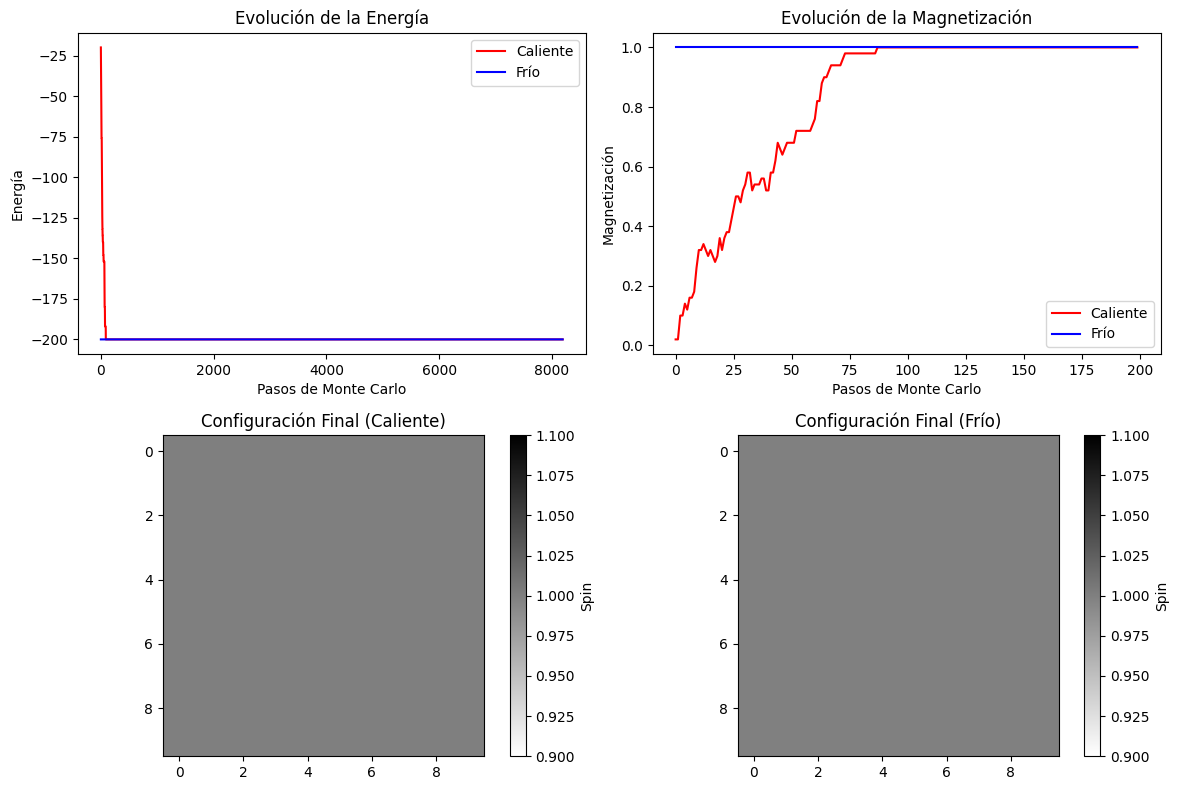

In [26]:
# Visualización de los resultados
import matplotlib.pyplot as plt

# print(result)

T = 0.1 ### temperatura que nos interesa graficar

energias_frio, magnetizaciones_frio, red_final_frio = params_a_result[('frio', T)]
energias_caliente, magnetizaciones_caliente, red_final_caliente = params_a_result[('caliente', T)]

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(energias_caliente[:], label='Caliente', color='r')
plt.plot(energias_frio[:], label='Frío', color='b')
plt.title("Evolución de la Energía")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Energía")
plt.legend()

plt.subplot(222)
plt.plot(magnetizaciones_caliente[:200], label='Caliente', color='r')
plt.plot(magnetizaciones_frio[:200], label='Frío', color='b')
plt.title("Evolución de la Magnetización")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Magnetización")
plt.legend()

plt.subplot(223)
plt.imshow(red_final_caliente, cmap='binary')
plt.title("Configuración Final (Caliente)")
plt.colorbar(label='Spin')

plt.subplot(224)
plt.imshow(red_final_frio, cmap='binary')
plt.title("Configuración Final (Frío)")
plt.colorbar(label='Spin')

plt.tight_layout()
plt.show()

## 4. Cálculo del Calor Específico y la Magnetización

In [27]:
def calor_especifico(energias, beta, T):
  energias_cuadrado = [E**2 for E in energias]
  promedio_energias = np.mean(energias)

  return (beta/T)*(np.mean(energias_cuadrado) - promedio_energias**2)

def susceptibilidad(magnetizaciones, beta):
  magnetizaciones_cuadrado = [M**2 for M in magnetizaciones]
  promedio_magnetizaciones = np.mean(magnetizaciones)

  return beta * ( np.mean(magnetizaciones_cuadrado) - promedio_magnetizaciones**2 )

for params, result in sorted(params_a_result.items()):
  S,T = params
  Es, Ms, red = result

  beta = 1.0/T

  C = calor_especifico(Es, beta, T)
  X = susceptibilidad(Ms, beta)

  print(f"Para {T:.{2}f} inicializada en {S}: C = {C:.{2}f}; X = {X:.{2}f}")

Para 0.10 inicializada en caliente: C = 6999.01; X = 0.02
Para 3.00 inicializada en caliente: C = 43.79; X = 0.03
Para 100.00 inicializada en caliente: C = 0.02; X = 0.00
Para 0.10 inicializada en frio: C = 0.00; X = 0.00
Para 3.00 inicializada en frio: C = 43.23; X = 0.04
Para 100.00 inicializada en frio: C = 0.02; X = 0.00


In [36]:
### Definimos una función para aplicar el algoritmo de metrópolis en un rango de
### temperaturas, pedimos un acumulador para almacenar los resultados

async def applicar_en_rtemp(temps, acc, L=10, H=0, J=1.0, N=2**13):
  loop = asyncio.get_event_loop()
  with ProcessPoolExecutor(max_workers=8) as exe:
    results = await asyncio.gather(*[
        async_metropolis_ising(loop, exe, L, H, J, 1/T, N) \
        for T in temps
    ])
    acc.update({t:[R[0], R[1]] for t,R in zip(temps, results)})


In [29]:
### Definimos esto en su propia celda para poder acumular los
### resultados de diferentes corridas si es necesario. Esto nos permite
### visualizar los resultados antes de hacer todas las simulaciones y nos
### permite usar las funciones (guardar_diccionario y cargar_diccionario)
### para guardar nuestro diccionario para otra sesión.

### Tendrá la forma de los parámetros temperatura y lado a resultados de esa
### temperatura y lado (T,L) -> R

### Cuando necesitemos hacer una visualización necesitaremos seleccionar de aquí
### el subconjunto de temperaturas y lados a graficar.



# Nombre del archivo para guardar/cargar el diccionario
tl_a_result_filename = 'tl_a_result.pickle'

# Intentar cargar el diccionario si el archivo existe
if os.path.exists(tl_a_result_filename):
    tl_a_result = cargar_diccionario(tl_a_result_filename)
else:
    tl_a_result = {}  # Inicializar un diccionario vacío si el archivo no existe

print(f"Diccionario tl_a_result cargado con {len(tl_a_result)} entradas.")

Diccionario cargado desde 'tl_a_result.pickle'
Diccionario tl_a_result cargado con 1105 entradas.


In [30]:
### Para encontrar el punto crítico, notamos que la susceptibilidad
### tiene ceros en los puntos extremos de la temperatura, por lo que
### debe tener al menos un máximo en el intérvalo. Este enfoque nos lo
### confirma una de las respuestas en:
### https://mattermodeling.stackexchange.com/questions/3930/ising-model-how-can-i-spot-the-critical-point

### Generaremos un rango de temperaturas en entre 1 y 3, con pasos cada vez más precisos
### en la vecindad del valor crítico teórico

L = 10

temps = [
    T for i in range(11) \
    if (T:= 1+i/(0.5*10.0)) and (T,L) not in tl_a_result
    ]

temps += [
    T for i in (1,2) for j in range(11) \
    if (T:= 2+j/(i*10.0)) and (T,L) not in tl_a_result
    ]

temps += [
    T for i in (4,) for j in range(11) \
    if (T:= 2.25+j/(i*10.0)) and (T,L) not in tl_a_result
    ]

acc =  {} ### acumulador temporal

print(f"Num. Simulaciones: {len(temps)}")
t0 = time.time()
await applicar_en_rtemp(temps, acc, L=L)
print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

for T,R in acc.items(): tl_a_result[(T,L)] = R  ### actualizando el acumulador global

Num. Simulaciones: 0
Las 0 simulaciones tomaron 0.001861572265625 s.


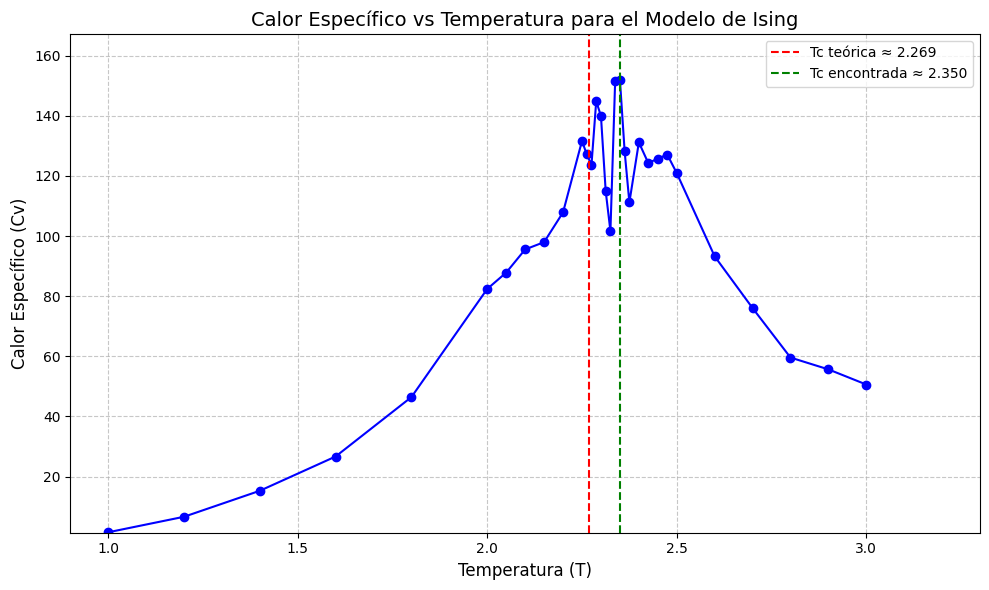

In [31]:
### Para visualizar la susceptibilidad comenzamos por recuperar las corridas que nos
### interesan del acumulador global, necesitamos generar las temperaturas de nuevo
### en caso de que haya otras corridas ya acumuladas en el diccionario


temps = [
    T for i in range(11) \
    if (T:= 1+i/(0.5*10.0))
    ]

temps += [
    T for i in (1,2) for j in range(11) \
    if (T:= 2+j/(i*10.0))
    ]

temps += [
    T for i in (4,8) for j in range(11) \
    if (T:= 2.25+j/(i*10.0))
    ]

temp_a_result = {
    T: R for T in temps if (R:= tl_a_result.get((T,10), None))
    }

temp_a_sus = { T: susceptibilidad(res[1], 1/T) for T, res in temp_a_result.items() }
temp_a_cv = {T: calor_especifico(res[0], 1/T, T) for T, res in temp_a_result.items() }

def graficar_cv(temp_a_cv):
    """
    Grafica la susceptibilidad magnética vs temperatura.

    :param temp_a_cv: Diccionario con temperaturas como claves y calores específicos como valores
    """
    # Ordenar el diccionario por temperatura para asegurar que la gráfica esté en orden
    datos_ordenados = sorted(temp_a_cv.items())
    temperaturas, susceptibilidades = zip(*datos_ordenados)

    # Encontrar la temperatura con la susceptibilidad máxima
    temp_max_sus = max(temp_a_cv, key=temp_a_cv.get)
    max_sus = temp_a_cv[temp_max_sus]

    plt.figure(figsize=(10, 6))
    plt.plot(temperaturas, susceptibilidades, 'b-', marker='o')
    # plt.semilogy(temperaturas, susceptibilidades, 'b-', marker='o')
    plt.xlabel('Temperatura (T)', fontsize=12)
    plt.ylabel('Calor Específico (Cv)', fontsize=12)
    plt.title('Calor Específico vs Temperatura para el Modelo de Ising', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Agregar un poco de espacio a los ejes x e y
    plt.xlim(min(temperaturas) * 0.9, max(temperaturas) * 1.1)
    plt.ylim(min(susceptibilidades) * 0.9, max(susceptibilidades) * 1.1)

    # Agregar línea para la temperatura crítica teórica
    temp_critica_teorica = 2.269  # Temperatura crítica teórica para el modelo de Ising 2D
    plt.axvline(x=temp_critica_teorica, color='r', linestyle='--',
                label=f'Tc teórica ≈ {temp_critica_teorica:.3f}')

    # Agregar línea para la temperatura de máxima susceptibilidad encontrada
    plt.axvline(x=temp_max_sus, color='g', linestyle='--',
                label=f'Tc encontrada ≈ {temp_max_sus:.3f}')

    plt.legend()
    plt.tight_layout()
    plt.show()


graficar_cv(temp_a_cv)

# Parte 2. Transición de Fase Ferromagnética



## 1. Verificando la relación entre el máximo Cv y ln(L)

In [ ]:
### Vamos a acumular esta vez resultados cerca del valor crítico de la temperatura
Tc = 2.269

Ls = [ L for L in range(30,9,-1) ] ### las redes más grandes primero


for L in Ls:

  temps = [
      T for n in range(-50,51,3) \
      if (T:=Tc - n*(0.01)) and (T,L) not in tl_a_result
  ]

  acc = {} ### acumulador interno

  print(f"Num. Simulaciones: {len(temps)}")
  t0 = time.time()
  await applicar_en_rtemp(temps, acc, L = L)
  print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

  for T,R in acc.items(): tl_a_result[(T,L)] = R ### actualizando acumulador global

Num. Simulaciones: 13
Las 13 simulaciones tomaron 100.78172492980957 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 188.8527705669403 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 181.94231128692627 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 182.4727373123169 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 165.0228841304779 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 157.21308994293213 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 146.306138753891 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 141.66147089004517 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 133.68529176712036 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 125.10764789581299 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 117.16902017593384 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 109.76834154129028 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 103.6372184753418 s.
Num. Simulaciones: 27
Las 27 simulaciones tomaron 96.13416719436646 s.

Diccionario guardado en 'tl_a_result.pickle'


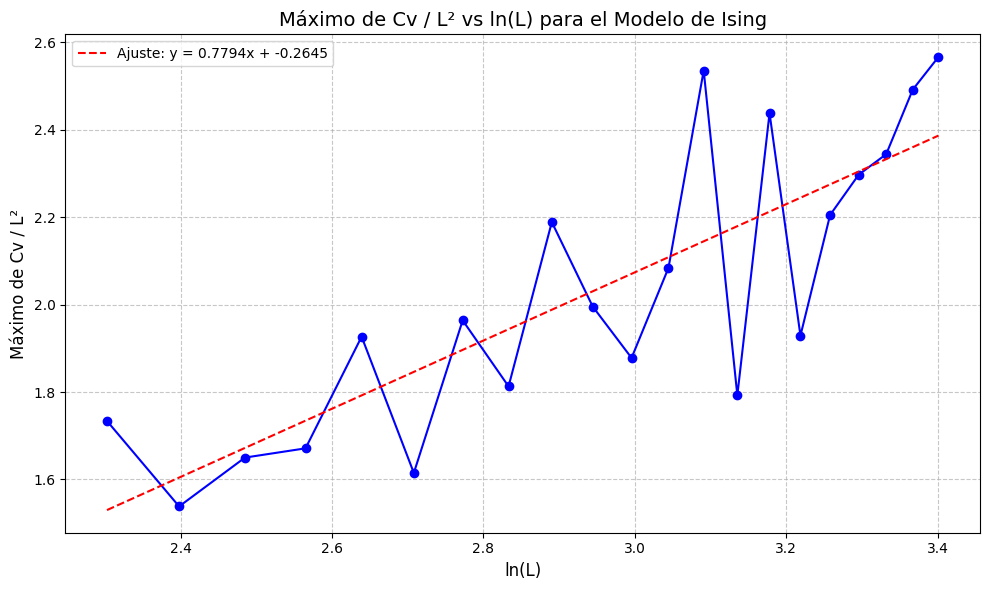

Pendiente del ajuste lineal: 0.7794
Intersección del ajuste lineal: -0.2645


In [ ]:

guardar_diccionario(tl_a_result, "tl_a_result.pickle")  ### guardando nuestro diccionario global


### Comenzamos de nuevo por seleccionar las simulaciones que nos interesa graficar
cv_sobre_l2 = lambda Es,T,L: calor_especifico(Es,1/T,T) / (L**2)

Tc = 2.269

L_a_Cv_max = {}
for L in range(30,9,-1):
  L_a_Cv_max[L] = []

  for n in range(-50,51,1):
    T = Tc - n*(0.01)
    R = tl_a_result.get((T,L), None)

    if R:
      L_a_Cv_max[L].append( cv_sobre_l2(R[0], T, L) )

  L_a_Cv_max[L] = max(L_a_Cv_max[L])

def graficar_Cv_max_vs_log_L(L_a_Cv_max):
    """
    Grafica el máximo del calor específico (Cv) sobre L^2 vs el logaritmo natural de L.

    :param L_a_Cv_max: Diccionario con L como claves y el máximo de Cv/L^2 como valores
    """
    # Ordenar el diccionario por L para asegurar que la gráfica esté en orden
    datos_ordenados = sorted(L_a_Cv_max.items())
    L_valores, Cv_max_valores = zip(*datos_ordenados)

    # Calcular el logaritmo natural de L
    log_L = np.log(L_valores)

    plt.figure(figsize=(10, 6))
    plt.plot(log_L, Cv_max_valores, 'bo-')
    plt.xlabel('ln(L)', fontsize=12)
    plt.ylabel('Máximo de Cv / L²', fontsize=12)
    plt.title('Máximo de Cv / L² vs ln(L) para el Modelo de Ising', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Ajuste lineal
    coef = np.polyfit(log_L, Cv_max_valores, 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(log_L, poly1d_fn(log_L), 'r--', label=f'Ajuste: y = {coef[0]:.4f}x + {coef[1]:.4f}')

    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Pendiente del ajuste lineal: {coef[0]:.4f}")
    print(f"Intersección del ajuste lineal: {coef[1]:.4f}")

graficar_Cv_max_vs_log_L(L_a_Cv_max)

## 2. Determinando γ

In [32]:
### Generamos las temperaturas, vamos a modificar el step de la función
### range para tener el rango que necesitamos, así podemos ir viendo nuestros
### resultados en borrador sin correr todas la 500 simulaciones de una vez

L=30
Tc = 2.269

temps = [ T for n in range(0, 501, 5) \
         if (T:= Tc - 0.001*n) and (T,L) not in tl_a_result ]

acc = {} ### acumulador local

print(f"Num. Simulaciones: {len(temps)}")
t0 = time.time()
await applicar_en_rtemp(temps, acc, L=L)
print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

for T,R in acc.items(): tl_a_result[(T,L)] = R ### actualizando acumulador global

Num. Simulaciones: 50
Las 50 simulaciones tomaron 410.3002288341522 s.


Diccionario guardado en 'tl_a_result.pickle'


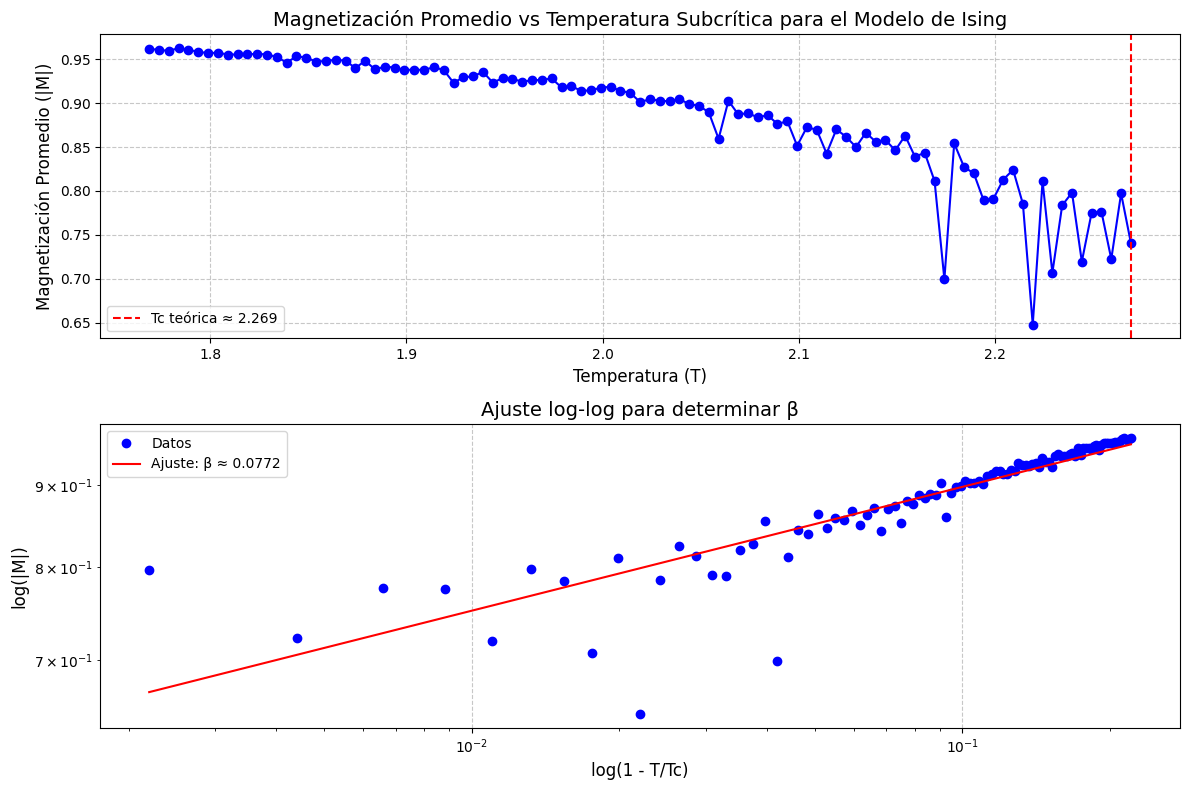

El valor estimado de β es: 0.0772
El valor estimado de γ es: 0.1543


In [35]:

guardar_diccionario(tl_a_result, "tl_a_result.pickle")  ### guardando nuestro diccionario global

temp_a_mag = {
    T: np.mean(R[1]) for n in range(0, 501, 1) \
    if (T:= Tc - 0.001*n) and (R:= tl_a_result.get((T,30), None))
}

def graficar_magnetizacion_vs_temperatura(temp_a_mag):
    """
    Grafica la magnetización promedio vs temperatura subcrítica y calcula gamma.

    :param temp_a_mag: Diccionario con temperaturas como claves y magnetizaciones promedio como valores
    """
    # Ordenar el diccionario por temperatura para asegurar que la gráfica esté en orden
    datos_ordenados = sorted(temp_a_mag.items())
    temperaturas, magnetizaciones = zip(*datos_ordenados)

    Tc_teorica = 2.269

    # Preparar datos para el ajuste
    t = np.array([(Tc_teorica - T) / Tc_teorica for T in temperaturas if T < Tc_teorica])
    m = np.array([mag for T, mag in zip(temperaturas, magnetizaciones) if T < Tc_teorica])

    # Ajuste logarítmico
    log_t = np.log(t)
    log_m = np.log(m)
    coef = np.polyfit(log_t, log_m, 1)
    beta = coef[0]

    plt.figure(figsize=(12, 8))

    # Gráfico principal
    plt.subplot(2, 1, 1)
    plt.plot(temperaturas, magnetizaciones, 'bo-')
    plt.xlabel('Temperatura (T)', fontsize=12)
    plt.ylabel('Magnetización Promedio (|M|)', fontsize=12)
    plt.title('Magnetización Promedio vs Temperatura Subcrítica para el Modelo de Ising', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axvline(x=Tc_teorica, color='r', linestyle='--', label=f'Tc teórica ≈ {Tc_teorica:.3f}')
    plt.legend()

    # Gráfico log-log
    plt.subplot(2, 1, 2)
    plt.loglog(t, m, 'bo', label='Datos')
    plt.loglog(t, np.exp(coef[1]) * t**beta, 'r-', label=f'Ajuste: β ≈ {beta:.4f}')
    plt.xlabel('log(1 - T/Tc)', fontsize=12)
    plt.ylabel('log(|M|)', fontsize=12)
    plt.title('Ajuste log-log para determinar β', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"El valor estimado de β es: {beta:.4f}")
    print(f"El valor estimado de γ es: {2 * beta:.4f}")

graficar_magnetizacion_vs_temperatura(temp_a_mag)

## 3. Encontrando ϵ

In [39]:
### Generamos las temperaturas, vamos a modificar el step de la función
### range para tener el rango que necesitamos, así podemos ir viendo nuestros
### resultados en borrador sin correr todas las simulaciones de una vez

L=30
Tc = 2.269
temps = [ T for n in range(0, 101, 1) \
         if (T:= Tc +0.1 +0.005*n) and (T,L) not in tl_a_result ]

acc = {} ### acumulador local

print(f"Num. Simulaciones: {len(temps)}")
t0 = time.time()
await applicar_en_rtemp(temps, acc, L=L)
print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

for T,R in acc.items(): tl_a_result[(T,L)] = R ### actualizando acumulador global

Num. Simulaciones: 26
Las 26 simulaciones tomaron 197.16371130943298 s.


Diccionario guardado en 'tl_a_result.pickle'


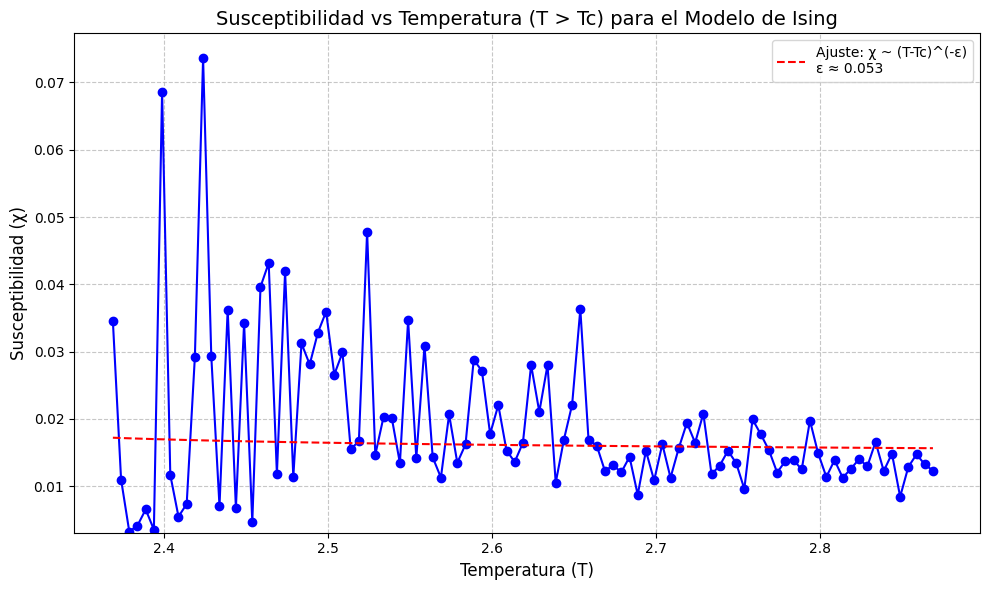

Exponente crítico estimado (ε): 0.0529
Temperatura mínima: 2.3690
Temperatura máxima: 2.8690
Susceptibilidad mínima: 0.0033
Susceptibilidad máxima: 0.0736


In [41]:
guardar_diccionario(tl_a_result, "tl_a_result.pickle")  ### guardando nuestro diccionario global

temp_a_susc = {
    T: susceptibilidad(R[1],1/T) for n in range(0, 101, 1) \
    if (T:= Tc +0.1 +0.005*n) and (R:= tl_a_result.get((T,30), None))
}

def graficar_susceptibilidad_vs_temperatura(temp_a_susc):
    """
    Grafica la susceptibilidad vs temperatura para T > Tc.

    :param temp_a_susc: Diccionario con temperaturas como claves y susceptibilidades como valores
    """
    # Ordenar el diccionario por temperatura para asegurar que la gráfica esté en orden
    datos_ordenados = sorted(temp_a_susc.items())
    temperaturas, susceptibilidades = zip(*datos_ordenados)

    plt.figure(figsize=(10, 6))
    plt.plot(temperaturas, susceptibilidades, 'bo-')
    plt.xlabel('Temperatura (T)', fontsize=12)
    plt.ylabel('Susceptibilidad (χ)', fontsize=12)
    plt.title('Susceptibilidad vs Temperatura (T > Tc) para el Modelo de Ising', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Añadir un poco de espacio alrededor de los datos
    plt.xlim(min(temperaturas) * 0.99, max(temperaturas) * 1.01)
    plt.ylim(min(susceptibilidades) * 0.95, max(susceptibilidades) * 1.05)

    # Añadir la temperatura crítica teórica
    Tc_teorica = 2.269
    # plt.axvline(x=Tc_teorica, color='g', linestyle='--', label=f'Tc teórica ≈ {Tc_teorica:.3f}')

    # Ajuste de ley de potencia
    log_temp = np.log(np.array(temperaturas) - Tc_teorica)
    log_susc = np.log(susceptibilidades)
    coef = np.polyfit(log_temp, log_susc, 1)
    epsilon_estimado = -coef[0]

    # Añadir línea de ajuste
    x_fit = np.linspace(min(temperaturas), max(temperaturas), 100)
    y_fit = np.exp(coef[1]) * (x_fit - Tc_teorica)**(-epsilon_estimado)
    plt.plot(x_fit, y_fit, '--', color='red', label=f'Ajuste: χ ~ (T-Tc)^(-ε)\nε ≈ {epsilon_estimado:.3f}')

    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Exponente crítico estimado (ε): {epsilon_estimado:.4f}")
    print(f"Temperatura mínima: {min(temperaturas):.4f}")
    print(f"Temperatura máxima: {max(temperaturas):.4f}")
    print(f"Susceptibilidad mínima: {min(susceptibilidades):.4f}")
    print(f"Susceptibilidad máxima: {max(susceptibilidades):.4f}")



graficar_susceptibilidad_vs_temperatura(temp_a_susc)